In [ ]:
!pip install statsmodels
!pip install pyod # Anomaly Detection Lib
!pip install fbprophet

In [ ]:
import pandas as pd
import numpy as np
import datetime

import statsmodels

import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%matplotlib
%matplotlib inline

Using matplotlib backend: agg


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Dataset CPU Usage - Minute


In [ ]:

df_cpu = pd.read_csv('/gdrive/My Drive/Estagio_OWS/Datasets/cpu.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
print(type(df_cpu))

<class 'pandas.core.series.Series'>


In [ ]:
df_cpu.head()

data
2020-07-11 00:00:00    27.6
2020-07-11 00:01:00     0.7
2020-07-11 00:02:00     1.0
2020-07-11 00:03:00     2.7
2020-07-11 00:04:00     0.9
Name: cpu, dtype: float64

In [ ]:
df_cpu.describe()

count    10080.000000
mean         3.928571
std          6.739948
min          0.100000
25%          0.400000
50%          1.800000
75%          4.100000
max        100.000000
Name: cpu, dtype: float64

# Plot Data: CPU Usage by minute

In [ ]:
import plotly.offline as py
import plotly.graph_objs as go

data = [go.Scatter(x=df_cpu.index,
                   y=df_cpu.values)]

config_layout = go.Layout(title='CPU Usage (minute)',
                          title_x=0.5,
                          yaxis={'title': 'CPU Usage by minute'},
                          xaxis={'title': 'Time'})                   

fig = go.Figure(data=data, layout=config_layout)

py.iplot(fig)

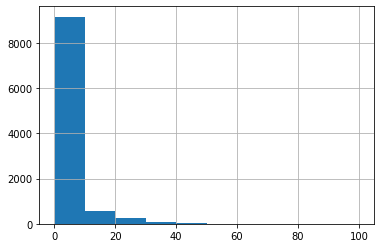

In [ ]:
df_cpu.hist()
plt.show()

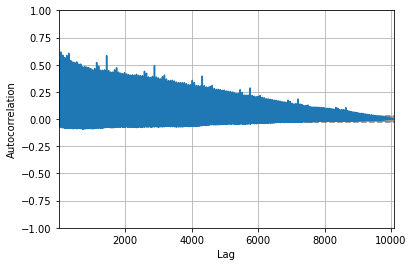

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_cpu)
plt.show()

# Time Series Forecasting:

### Components of Time Series:
1. Level
2. Trend
3. Seasonality
4. Noise

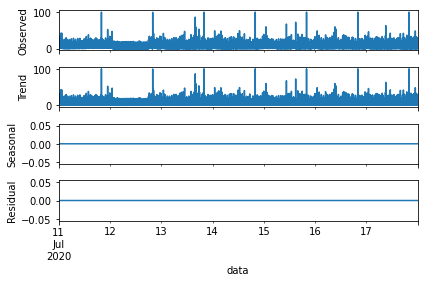

In [ ]:
# Decomposing time series - Exploring Trend and Seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

result = seasonal_decompose(df_cpu, model='additive', freq=1)
result.plot()
pyplot.show()


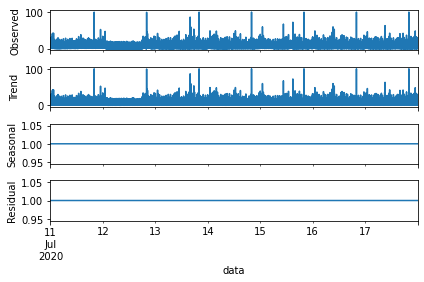

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

result = seasonal_decompose(df_cpu, model='multiplicative', freq=1)
result.plot()
pyplot.show()


# Stationary Time Series x Non Stationary

## Non Stationary: 
  - Show seasonal and trend effects. Statistics like mean and variance change over time.

## Stationary:
  - Do not have a  trend or seasonality. 


There are two important forms of stationarity: strong stationarity and weak stationarity. 

A time series is defined as having a strong stationarity when all its statistical parameters do not change over time. 

A time series is defined as having a weak stationarity when its mean and auto-covariance functions do not change over time.

--------------------------

Non Stationary time series are harder to predict.

Classical time series analysis and forecasting methods are concerned with making non-stationary time series data stationary by identifying and removing trends and removing seasonal efects.




# Check for Stationary
 - Statistical tests: Augmented Dickey-fuller test

    - p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    - p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_cpu.values)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))


ADF Statistic: -9.496230
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


# Time Series Forecasting as Supervised Learning: Sliding Window Method

Time series data can be expressed as a supervised learning problem: data cientists usually transform their time series data sets into a supervised learning by exploiting previous time steps and using them as input and then leveraging the next time step as output of the model.

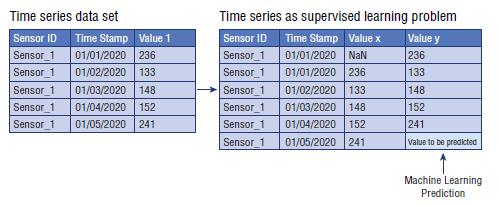



# Window Size or Lag:
## Lag is the number of time steps that data will be shifted/moved.
Eg.: Lag = 1 -> value at time t will be moved to one step ahead, to time = t+1

In [ ]:
# Shift data
print('Original Data: \n',df_cpu.head())

Original Data: 
 data
2020-07-11 00:00:00    27.6
2020-07-11 00:01:00     0.7
2020-07-11 00:02:00     1.0
2020-07-11 00:03:00     2.7
2020-07-11 00:04:00     0.9
Name: cpu, dtype: float64


In [ ]:
# Shifted data- Lag+1: 
df_cpu_lag1 = df_cpu.shift(1)
print('Data Lag+1: \n',df_cpu_lag1.head())

# Value 27.6 originally at time 2020-07-11 00:00:00 was moved to 1 step ahead, to time 2020-07-11 00:01:00

Data Lag+1: 
 data
2020-07-11 00:00:00     NaN
2020-07-11 00:01:00    27.6
2020-07-11 00:02:00     0.7
2020-07-11 00:03:00     1.0
2020-07-11 00:04:00     2.7
Name: cpu, dtype: float64


In [ ]:
# Shifted data- Lag+2:
df_cpu_lag2 = df_cpu.shift(2)
print('Data Lag+2: \n',df_cpu_lag2.head())

# Value 27.6 originally at time 2020-07-11 00:00:00 was moved 2 steps ahead, to time 2020-07-11 00:02:00

Data Lag+2: 
 data
2020-07-11 00:00:00     NaN
2020-07-11 00:01:00     NaN
2020-07-11 00:02:00    27.6
2020-07-11 00:03:00     0.7
2020-07-11 00:04:00     1.0
Name: cpu, dtype: float64


# Creating a New DataFrame using Sliding Window Method

For test purposes Lag size used is 5 steps.

In [ ]:
# Creating a new dataframe. Moving time to 5 steps ahead.
temp = pd.DataFrame(df_cpu.values)
df_cpu_slwin = pd.concat([temp.shift(5),temp.shift(4),temp.shift(3),temp.shift(2), temp.shift(1), temp], axis=1) 
df_cpu_slwin.columns = ['t-4', 't-3', 't-2','t-1','t','t+1']

In [ ]:
df_cpu_slwin.head(10)

,t-4,t-3,t-2,t-1,t,t+1
0,NaN,NaN,NaN,NaN,NaN,27.6
1,NaN,NaN,NaN,NaN,27.6,0.7
2,NaN,NaN,NaN,27.6,0.7,1.0
3,NaN,NaN,27.6,0.7,1.0,2.7
4,NaN,27.6,0.7,1.0,2.7,0.9
5,27.6,0.7,1.0,2.7,0.9,4.2
6,0.7,1.0,2.7,0.9,4.2,1.1
7,1.0,2.7,0.9,4.2,1.1,0.6
8,2.7,0.9,4.2,1.1,0.6,3.0
9,0.9,4.2,1.1,0.6,3.0,0.8


In [ ]:
df_cpu_slwin.tail(10)

,t-4,t-3,t-2,t-1,t,t+1
10070,2.6,0.3,0.2,2.5,0.3,4.1
10071,0.3,0.2,2.5,0.3,4.1,0.3
10072,0.2,2.5,0.3,4.1,0.3,1.0
10073,2.5,0.3,4.1,0.3,1.0,2.9
10074,0.3,4.1,0.3,1.0,2.9,6.2
10075,4.1,0.3,1.0,2.9,6.2,29.8
10076,0.3,1.0,2.9,6.2,29.8,8.7
10077,1.0,2.9,6.2,29.8,8.7,13.6
10078,2.9,6.2,29.8,8.7,13.6,2.1
10079,6.2,29.8,8.7,13.6,2.1,0.5


In [ ]:
# remove first rows with NaN values.
df_cpu_slwin = df_cpu_slwin.iloc[5:]

# reset DataFrame index
df_cpu_slwin.reset_index(inplace=True, drop=True)

In [ ]:
df_cpu_slwin.head(10)

,t-4,t-3,t-2,t-1,t,t+1
0,27.6,0.7,1.0,2.7,0.9,4.2
1,0.7,1.0,2.7,0.9,4.2,1.1
2,1.0,2.7,0.9,4.2,1.1,0.6
3,2.7,0.9,4.2,1.1,0.6,3.0
4,0.9,4.2,1.1,0.6,3.0,0.8
5,4.2,1.1,0.6,3.0,0.8,3.7
6,1.1,0.6,3.0,0.8,3.7,13.2
7,0.6,3.0,0.8,3.7,13.2,1.3
8,3.0,0.8,3.7,13.2,1.3,2.9
9,0.8,3.7,13.2,1.3,2.9,11.7


### Univariate Time Series was converted to a dataframe where t+1 is the value to be predicted (Y)

In [ ]:
X = df_cpu_slwin.iloc[:, 0:5]

In [ ]:
X.head()

,t-4,t-3,t-2,t-1,t
0,27.6,0.7,1.0,2.7,0.9
1,0.7,1.0,2.7,0.9,4.2
2,1.0,2.7,0.9,4.2,1.1
3,2.7,0.9,4.2,1.1,0.6
4,0.9,4.2,1.1,0.6,3.0


In [ ]:
Y = df_cpu_slwin.iloc[:, 5]

In [ ]:
Y.head()

0    4.2
1    1.1
2    0.6
3    3.0
4    0.8
Name: t+1, dtype: float64

In [ ]:
X.shape, Y.shape

((10075, 5), (10075,))

In [ ]:
# Normalize data min-max:



## Cross Validation using Rolling Window

In [ ]:
# Cross validation using Rolling Window
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)

## Training model using neural network

In [ ]:
from keras.initializers import glorot_normal
from keras.regularizers import l1, l2
from keras.models import Sequential
from keras.layers import Dense


cvscores = []

for train, test in tscv.split(X,Y):

  model = Sequential()
  model.add(Dense(10, kernel_regularizer=l1(0.0001),
                  kernel_initializer='glorot_normal',
                  activation='relu',
                  name='hidden-input1'))

  model.add(Dense(10, kernel_regularizer=l1(0.0001),
                  kernel_initializer='glorot_normal',
                  activation='relu',
                  name='hidden-input2'))
  
  model.add(Dense(1, 
                  kernel_regularizer=l1(0.0001),
                  kernel_initializer='glorot_normal',
                  activation='relu',
                  name='output'))
  
  model.compile(loss='mse', optimizer='adam', metrics=['mse'])

  model.fit(X.iloc[train], Y.iloc[train], epochs=100, batch_size=5, verbose=0, shuffle=False,
            validation_data=(X.iloc[test], Y.iloc[test]))
  
  scores = model.evaluate(X.iloc[test], Y.iloc[test], verbose=0)

  print(model.metrics_names[1], scores[1])
  cvscores.append(scores[1])

print(np.mean(cvscores), np.std(cvscores))


mse 50.16130447387695
mse 28.192583084106445
mse 29.064956665039062
mse 55.6346321105957
mse 23.710988998413086
mse 45.56776428222656
mse 35.33787536621094
mse 32.548011779785156
mse 36.28907775878906
mse 39.06101989746094
37.55682144165039 9.6708061850533


# ARIMA - Autoregressive Integrated Moving Average Model

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.





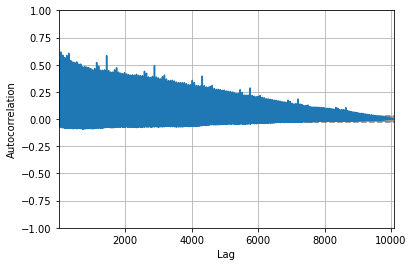

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_cpu)
pyplot.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency T will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency T will be used.



                             ARIMA Model Results                              
Dep. Variable:                  D.cpu   No. Observations:                10079
Model:                ARIMA(10, 1, 1)   Log Likelihood              -32995.667
Method:                       css-mle   S.D. of innovations              6.389
Date:                Tue, 26 Jan 2021   AIC                          66017.333
Time:                        18:51:10   BIC                          66111.170
Sample:                    07-11-2020   HQIC                         66049.084
                         - 07-17-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.425e-05      0.001     -0.094      0.925      -0.001       0.001
ar.L1.D.cpu      0.0840      0.010      8.374      0.000       0.064       0.104
ar.L2.D.cpu      0.0440      0.010      4.38

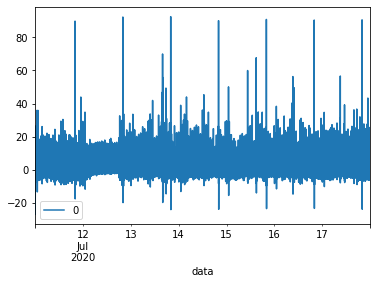

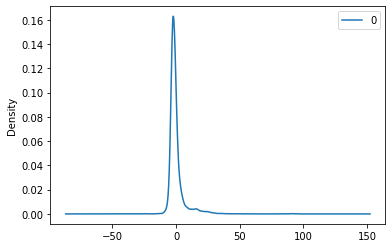

                  0
count  10079.000000
mean      -0.009183
std        6.393339
min      -26.899946
25%       -2.901443
50%       -1.508076
75%        0.391689
max       92.509347


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(df_cpu, order=(10,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
import warnings
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

# grid search ARIMA parameters for time series

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
#series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_cpu.values, p_values, d_values, q_values)


ARIMA(0, 0, 0) RMSE=6.901


# ANOMALY DETECTION 

# Library ADTK

Anomaly Detection Toolkit (ADTK) is a Python package for unsupervised / rule-based time series anomaly detection.

In [ ]:
!pip install adtk

     |████████████████████████████████| 61kB 2.7MB/s 


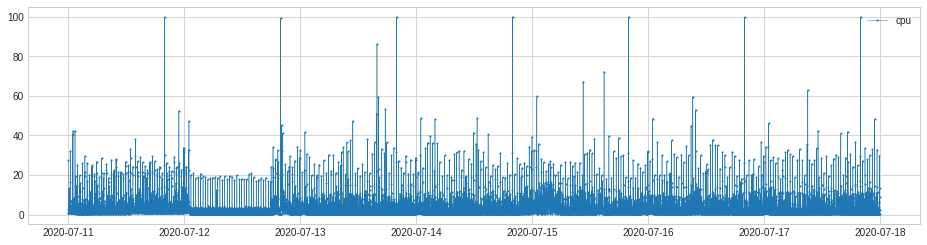

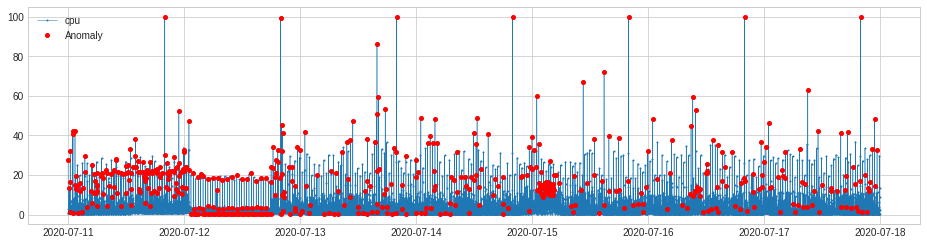

In [ ]:
from adtk.detector import SeasonalAD
from adtk.visualization import plot
from adtk.data import validate_series

s_train = validate_series(df_cpu)

plot(s_train)

seasonal_ad = SeasonalAD()
anomalies = seasonal_ad.fit_detect(s_train)
plot(s_train, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")
plt.show()

## AutoregressionAD



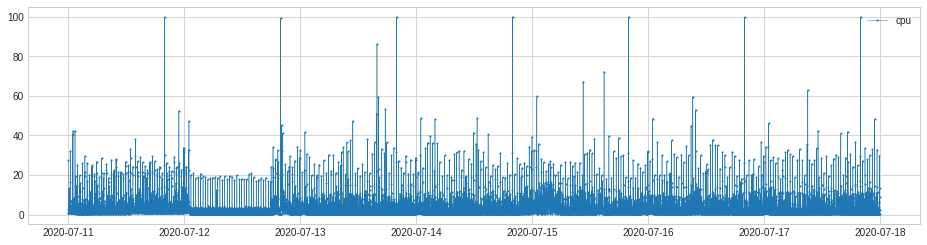

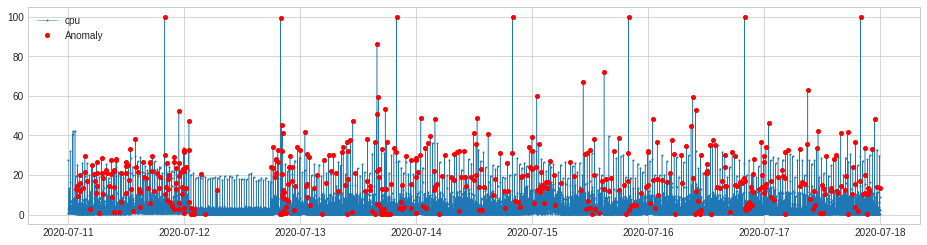

In [ ]:
from adtk.detector import AutoregressionAD


plot(s_train)

autoreg_ad = AutoregressionAD(n_steps=100, step_size=1)
anomalies = autoreg_ad.fit_detect(s_train)
plot(s_train, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")
plt.show()

## GeneralizedESDTestAD

Detector that detects anomaly based on generalized ESD test.


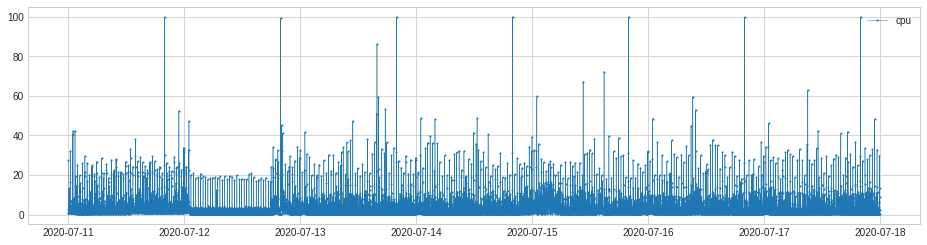

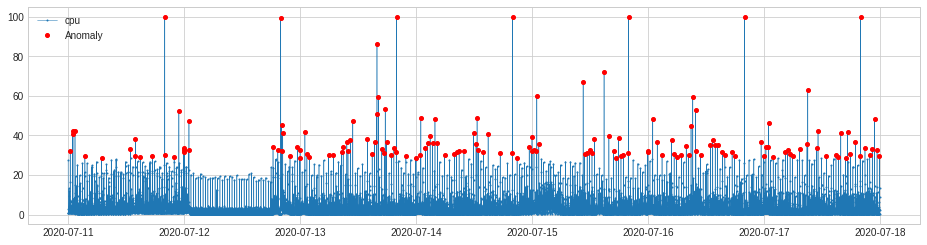

In [ ]:
from adtk.detector import GeneralizedESDTestAD

plot(s_train)

generalized_ad = GeneralizedESDTestAD(alpha=0.001)
anomalies = generalized_ad.fit_detect(s_train)
plot(s_train, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")
plt.show()

# ThresholdAD

Detector that detects anomaly based on user-given threshold.

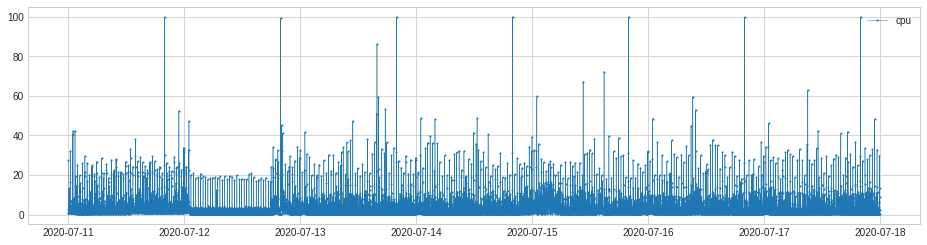

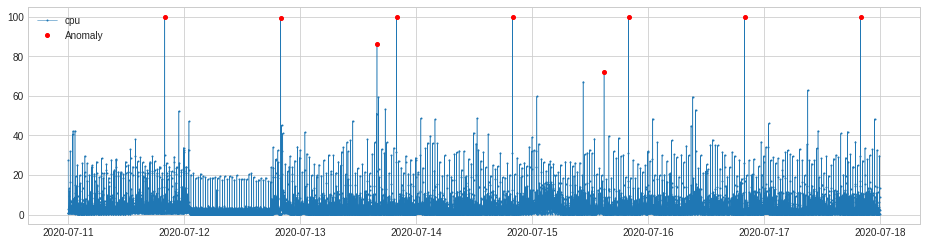

In [ ]:
from adtk.detector import ThresholdAD

plot(s_train)

threshold_ad = ThresholdAD(high=70)
anomalies = threshold_ad.detect(s_train)
plot(s_train, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")
plt.show()

# Feature Engineering - Create new date-time based features:

In [ ]:
df_cpu.describe()

count    10080.000000
mean         3.928571
std          6.739948
min          0.100000
25%          0.400000
50%          1.800000
75%          4.100000
max        100.000000
Name: cpu, dtype: float64

In [ ]:
df_cpu.head()

data
2020-07-11 00:00:00    27.6
2020-07-11 00:01:00     0.7
2020-07-11 00:02:00     1.0
2020-07-11 00:03:00     2.7
2020-07-11 00:04:00     0.9
Name: cpu, dtype: float64

In [ ]:
type(df_cpu)

pandas.core.series.Series

In [ ]:
df_cpu_new = pd.DataFrame(df_cpu)
type(df_cpu_new)

pandas.core.frame.DataFrame

In [ ]:
df_cpu_new.head()

,cpu
data,
2020-07-11 00:00:00,27.6
2020-07-11 00:01:00,0.7
2020-07-11 00:02:00,1.0
2020-07-11 00:03:00,2.7
2020-07-11 00:04:00,0.9


In [ ]:
df_cpu_new.cpu

data
2020-07-11 00:00:00    27.6
2020-07-11 00:01:00     0.7
2020-07-11 00:02:00     1.0
2020-07-11 00:03:00     2.7
2020-07-11 00:04:00     0.9
                       ... 
2020-07-17 23:55:00    29.8
2020-07-17 23:56:00     8.7
2020-07-17 23:57:00    13.6
2020-07-17 23:58:00     2.1
2020-07-17 23:59:00     0.5
Name: cpu, Length: 10080, dtype: float64

In [ ]:
# Create new features for minute, hour day, month and year
df_cpu_new['year'] = df_cpu_new.index.year
df_cpu_new['month'] = df_cpu_new.index.month
df_cpu_new['day'] = df_cpu_new.index.day
df_cpu_new['hour'] = df_cpu_new.index.hour
df_cpu_new['minute'] = df_cpu_new.index.minute

df_cpu_new.head()

,cpu,year,month,day,hour,minute
data,,,,,,
2020-07-11 00:00:00,27.6,2020,7,11,0,0
2020-07-11 00:01:00,0.7,2020,7,11,0,1
2020-07-11 00:02:00,1.0,2020,7,11,0,2
2020-07-11 00:03:00,2.7,2020,7,11,0,3
2020-07-11 00:04:00,0.9,2020,7,11,0,4


In [ ]:
# create lag features of 2 steps
df_cpu_new['t-1'] = df_cpu_new.cpu.shift(2)
df_cpu_new['t'] = df_cpu_new.cpu.shift(1)
df_cpu_new['t+1'] = df_cpu_new.cpu

In [ ]:
df_cpu_new.head(10)

,cpu,year,month,day,hour,minute,t-1,t,t+1
data,,,,,,,,,
2020-07-11 00:00:00,27.6,2020,7,11,0,0,NaN,NaN,27.6
2020-07-11 00:01:00,0.7,2020,7,11,0,1,NaN,27.6,0.7
2020-07-11 00:02:00,1.0,2020,7,11,0,2,27.6,0.7,1.0
2020-07-11 00:03:00,2.7,2020,7,11,0,3,0.7,1.0,2.7
2020-07-11 00:04:00,0.9,2020,7,11,0,4,1.0,2.7,0.9
2020-07-11 00:05:00,4.2,2020,7,11,0,5,2.7,0.9,4.2
2020-07-11 00:06:00,1.1,2020,7,11,0,6,0.9,4.2,1.1
2020-07-11 00:07:00,0.6,2020,7,11,0,7,4.2,1.1,0.6
2020-07-11 00:08:00,3.0,2020,7,11,0,8,1.1,0.6,3.0


In [ ]:
# remove null rows
df_cpu_new.dropna(inplace=True)
df_cpu_new.head()

,cpu,year,month,day,hour,minute,t-1,t,t+1
data,,,,,,,,,
2020-07-11 00:02:00,1.0,2020,7,11,0,2,27.6,0.7,1.0
2020-07-11 00:03:00,2.7,2020,7,11,0,3,0.7,1.0,2.7
2020-07-11 00:04:00,0.9,2020,7,11,0,4,1.0,2.7,0.9
2020-07-11 00:05:00,4.2,2020,7,11,0,5,2.7,0.9,4.2
2020-07-11 00:06:00,1.1,2020,7,11,0,6,0.9,4.2,1.1


In [ ]:
# remove column cpu (duplicated)
df_cpu_new.drop(columns=['cpu'], inplace=True)
df_cpu_new.head()

,year,month,day,hour,minute,t-1,t,t+1
data,,,,,,,,
2020-07-11 00:02:00,2020,7,11,0,2,27.6,0.7,1.0
2020-07-11 00:03:00,2020,7,11,0,3,0.7,1.0,2.7
2020-07-11 00:04:00,2020,7,11,0,4,1.0,2.7,0.9
2020-07-11 00:05:00,2020,7,11,0,5,2.7,0.9,4.2
2020-07-11 00:06:00,2020,7,11,0,6,0.9,4.2,1.1


# Train a Neural Network:

In [ ]:
X = df_cpu_new.iloc[:, 0:-1]
Y = df_cpu_new.iloc[:, -1]

In [ ]:
print(X.head())
print(Y.head())

                     year  month  day  hour  minute   t-1    t
data                                                          
2020-07-11 00:02:00  2020      7   11     0       2  27.6  0.7
2020-07-11 00:03:00  2020      7   11     0       3   0.7  1.0
2020-07-11 00:04:00  2020      7   11     0       4   1.0  2.7
2020-07-11 00:05:00  2020      7   11     0       5   2.7  0.9
2020-07-11 00:06:00  2020      7   11     0       6   0.9  4.2
data
2020-07-11 00:02:00    1.0
2020-07-11 00:03:00    2.7
2020-07-11 00:04:00    0.9
2020-07-11 00:05:00    4.2
2020-07-11 00:06:00    1.1
Name: t+1, dtype: float64


## Cross Validation using Rolling Window



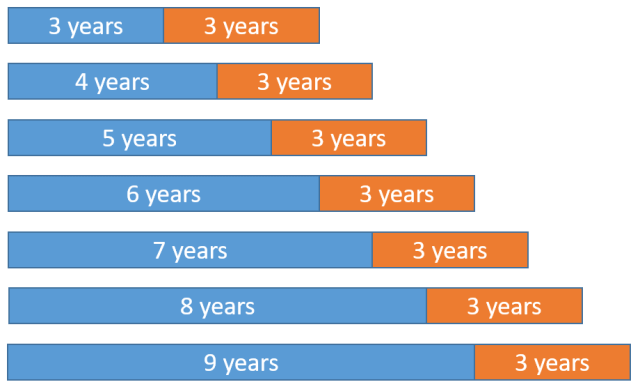


In [ ]:
# Cross validation using Rolling Window
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

## Training model using neural network

In [ ]:
# Function to plot Loss Accuracy - Train x Val
def plot_loss_accuracy(m):
    linestyles = ['-', '--', ':', '-.']
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

    #Plot Loss
    ax1.plot(m.history['loss'], linestyle=":")
    ax1.plot(m.history['val_loss'], linestyle=":")
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    #Plot ACC
    ax2.plot(m.history['accuracy'], linestyle="-")
    ax2.plot(m.history['val_accuracy'], linestyle="-")
    ax2.set_ylabel('ACC')
    ax2.set_xlabel('Epoch')
    
    plt.legend(["train", "val"], bbox_to_anchor=(1.05, 1), loc='center left')    
    plt.subplots_adjust(right=0.75)
    plt.show()

mse 34.96559524536133


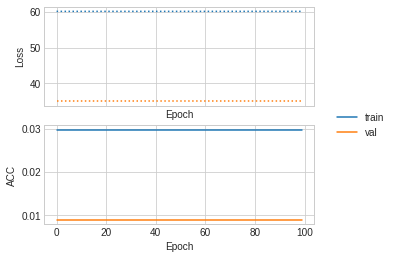

mse 60.357093811035156


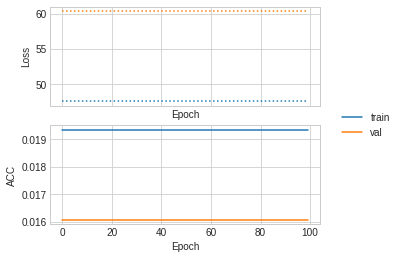

mse 57.51591873168945


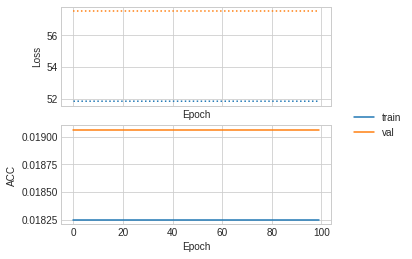

mse 57.13186264038086


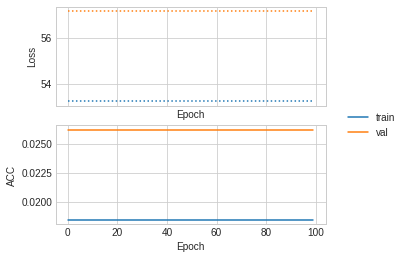

mse 53.44479751586914


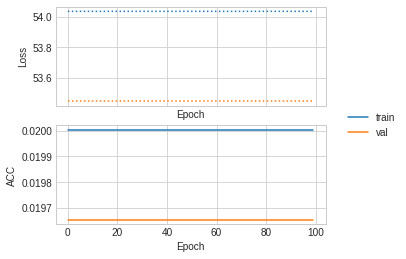

52.68305358886719 9.12718976203714


In [ ]:
from keras.initializers import glorot_normal
from keras.regularizers import l1, l2
from keras.models import Sequential
from keras.layers import Dense


cvscores = []

for train, test in tscv.split(X,Y):

  model = Sequential()
  model.add(Dense(10, kernel_regularizer=l2(0.0001),
                  kernel_initializer='random_normal',
                  activation='softmax',
                  name='hidden-input1'))

  model.add(Dense(10, kernel_regularizer=l2(0.001),
                  kernel_initializer='random_normal',
                  activation='softmax',
                  name='hidden-input2'))
  
  model.add(Dense(1, 
                  kernel_regularizer=l2(0.001),
                  kernel_initializer='random_normal',
                  activation='softmax',
                  name='output'))
  
  model.compile(loss='mse', optimizer='adam', metrics=['mse', 'accuracy'])

  history = model.fit(X.iloc[train], Y.iloc[train], epochs=100, batch_size=5, verbose=0, shuffle=False,
            validation_data=(X.iloc[test], Y.iloc[test]))
  
  scores = model.evaluate(X.iloc[test], Y.iloc[test], verbose=0)

  print(model.metrics_names[1], scores[1])
  cvscores.append(scores[1])
  plot_loss_accuracy(history)
  #print(model.metrics_names)

print(np.mean(cvscores), np.std(cvscores))


In [ ]:
model.summary()

# Library PyOD

In [ ]:
!pip install pyod

In [ ]:
from pyod.models.base import BaseDetector

pyod_bd = BaseDetector(contamination=0.01)
anomalies = pyod_bd.fit(s_train)